# Analyzing Census Tract Data
This notebook consists of all the analyses used for our paper.

In [1]:
import geopandas as gpd
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import descartes
from shapely.geometry import Point, Polygon

## Pittsburgh, PA

Data sets used include the ACS 5-Year Estimates Data Profile for 2019 and the Healthy Ride bike station locations.

Anlayses for Pittsburgh, PA include the following:
- Relationship of bike station locations and population by census tract
- Relationship of bike station locations and income by census tract
- Relationship of bike station locations and commuting pto work patterns
- Relationship of bike station locations and poor housing conditions

In [28]:
# load in all the data sets we are going to use for this analysis

hr_df = pd.read_csv("../Data/bikes_station_location.csv") #location of healthy ride bike stations
cm_df = pd.read_csv("../Data/CensusTractData/commuting_data_pa.csv") #commnuting to work category from ACS for census tracts in allegheny county
in_df = pd.read_csv("../Data/CensusTractData/income_data_pa.csv") #income and benefitis category from ACS for census tracts in alleghney county
pop_df = pd.read_csv("../Data/CensusTractData/employment_data_pa.csv") #employment and population category from ACS for census tracts in allegheny county

#get the 2010 census tracts in Pittsburgh
cenTract = gpd.read_file('../Data/2010_Census_Tracts/2010_Census_Tracts-shp/2010_Census_Tracts.shp')
#'../Data/2010_Census_Tracts/a36fc9b1-4e53-4fd1-80fb-db1554e213422020328-1-nbfxcj.l6b8.shp' is the same file

In [3]:
#convert hr_df to geodataframe to plot the bike stations on map
geometry = [Point(xy) for xy in zip(hr_df.Longitude, hr_df.Latitude)]
crs = 4326
hr_gdf = gpd.GeoDataFrame(hr_df, crs=crs, geometry=geometry)

Text(0.5, 1.0, 'Bike Station Locations')

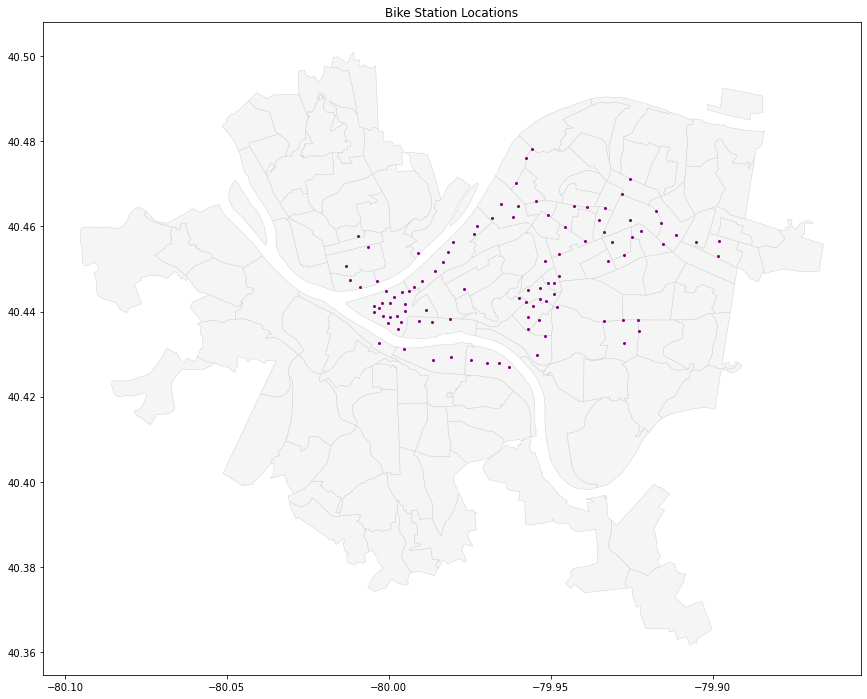

In [49]:
#plot the census tracts and the location of the bike stations
ax = cenTract.plot(figsize = (15, 12), color = "whitesmoke", edgecolor = "lightgrey", linewidth = 0.5)
hr_gdf.plot(ax=ax, color="Purple", markersize=4)
plt.title("Bike Station Locations")

### Commuting to Work Patterns by Census Tract
Analyzing the relationship between the location of the bike stations and the commuting to work patterns of each census tract

#### Cleaning the dataframe

In [5]:
cm_df = cm_df.drop(columns=['Unnamed: 0'])
cm_df = cm_df.astype({'tractce10': 'str'})

for row, col in cm_df.iterrows():
    #fix census tract number
    cen_num = cm_df.loc[row]['tractce10']
    if len(cen_num) < 6:
        cen_num = '0' + cen_num
    cm_df.at[row, 'tractce10'] = cen_num
        
cm_df.head(1)

,tractce10,Workers_16yrs+,own_alone,carpool,public_transit,walked,other,wfh,mean_travel_time_to_work
0,010300,1507,413,102,159,684,9,140,15.0


#### Match tracts in cm_df to cenTract

In [6]:
cenTract.tractce10.astype(str)
merged_df = cenTract.merge(cm_df, on="tractce10")
merged_df.head(1)

,objectid,statefp10,countyfp10,tractce10,blkgrpce10,geoid10,namelsad10,mtfcc10,funcstat10,aland10,...,Shape__Len,geometry,Workers_16yrs+,own_alone,carpool,public_transit,walked,other,wfh,mean_travel_time_to_work
0,1,42,003,040500,1,420030405001,Block Group 1,G5030,S,268195,...,10442.03645,"POLYGON ((-79.95304 40.44203, -79.95302 40.442...",1476,426,58,273,691,10,18,16.0


#### Plotting the number of people who drove alone to work
Here we make an inference that those who drove alone to work own or lease their vehicle.

In [56]:
merged_df['perc_alone'] = merged_df['own_alone'] / merged_df['Workers_16yrs+']
merged_df['perc_public'] = merged_df['public_transit'] / merged_df['Workers_16yrs+']
merged_df['perc_combo'] = (merged_df['public_transit'] + merged_df['walked'] + merged_df['other']) / merged_df['Workers_16yrs+']
merged_df['perc_walk'] = merged_df['walked'] / merged_df['Workers_16yrs+']
merged_df['perc_other'] = merged_df['other'] / merged_df['Workers_16yrs+']

for row, col in merged_df.iterrows():
    if pd.isna(merged_df.loc[row]['perc_alone']):
        merged_df.at[row,'perc_alone'] = 0
    if pd.isna(merged_df.loc[row]['perc_public']):
        merged_df.at[row,'perc_public'] = 0
    if pd.isna(merged_df.loc[row]['perc_combo']):
        merged_df.at[row,'perc_combo'] = 0
    if pd.isna(merged_df.loc[row]['perc_walk']):
        merged_df.at[row,'perc_walk'] = 0
    if pd.isna(merged_df.loc[row]['perc_other']):
        merged_df.at[row,'perc_other'] = 0
    if pd.isna(merged_df.loc[row]['mean_travel_time_to_work']):
        merged_df.at[row,'mean_travel_time_to_work'] = 0

Text(0.5, 1.0, 'Percent of people who commute to work alone by census tract in relation to Healthy Ride bike station locations.')

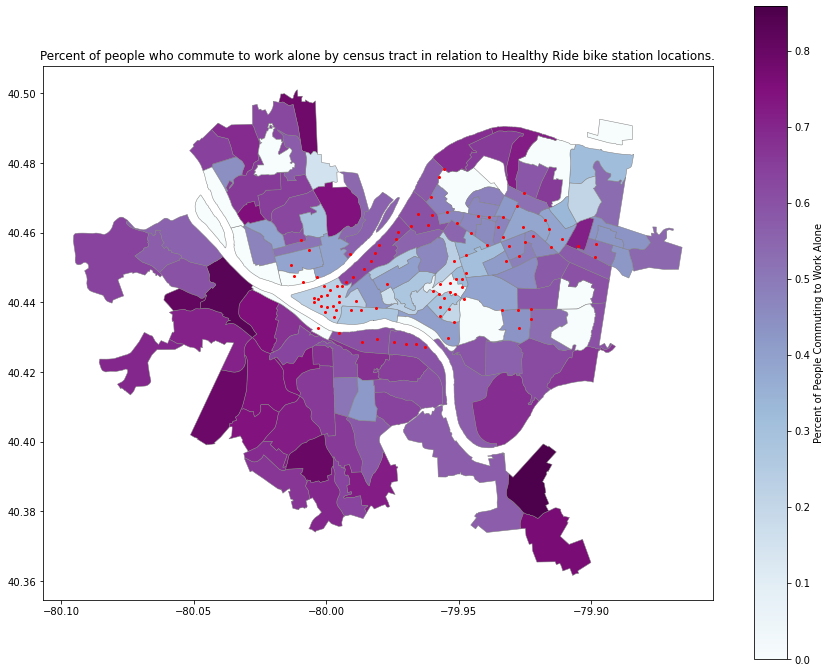

In [50]:
ax_cm = merged_df.plot(column="perc_alone", cmap='BuPu', figsize = (15, 12), edgecolor = "grey", linewidth = 0.5, 
                       legend=True, legend_kwds={'label': "Percent of People Commuting to Work Alone",
                                                 'orientation': "vertical"})
#add the bike station locations
hr_gdf.plot(ax=ax_cm, color="Red", markersize=4)
plt.title("Percent of people who commute to work alone by census tract in relation to Healthy Ride bike station locations.")

#### Plotting the percentage of people who use public transit

Text(0.5, 1.0, 'Percent of people who commute to work via public transit by census tract in relation to Healthy Ride bike stations.')

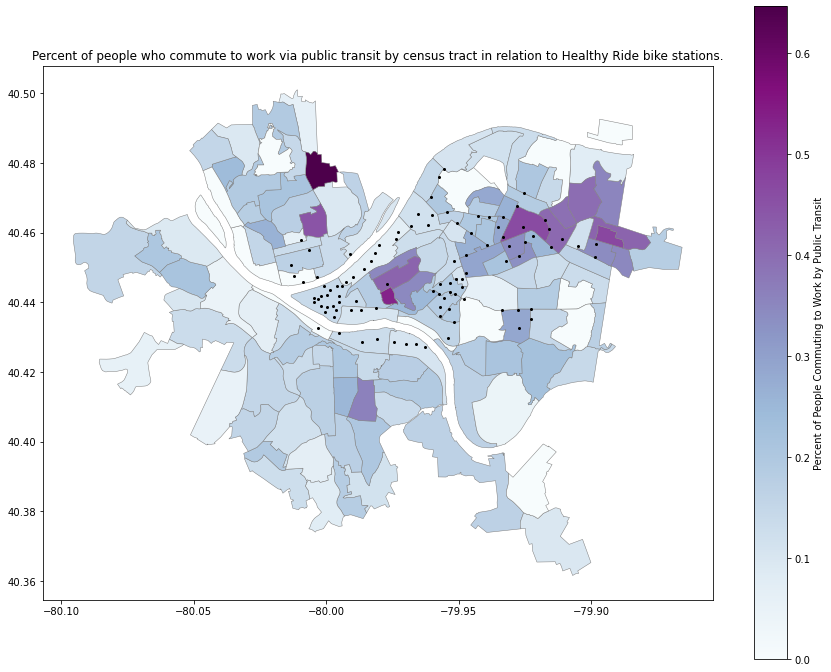

In [51]:
ax_cm2 = merged_df.plot(column="perc_public", cmap='BuPu', figsize = (15, 12), edgecolor = "grey", linewidth = 0.5, 
                        legend=True, legend_kwds={'label': "Percent of People Commuting to Work by Public Transit",
                                                  'orientation': "vertical"})
#add the bike station locations
hr_gdf.plot(ax=ax_cm2, color="Black", markersize=4)
plt.title("Percent of people who commute to work via public transit by census tract in relation to Healthy Ride bike stations.")

#### Plotting the percentage of people who walk

Text(0.5, 1.0, 'Percent of people who commute to work by walking by census tract in relation to Health Ride bike stations.')

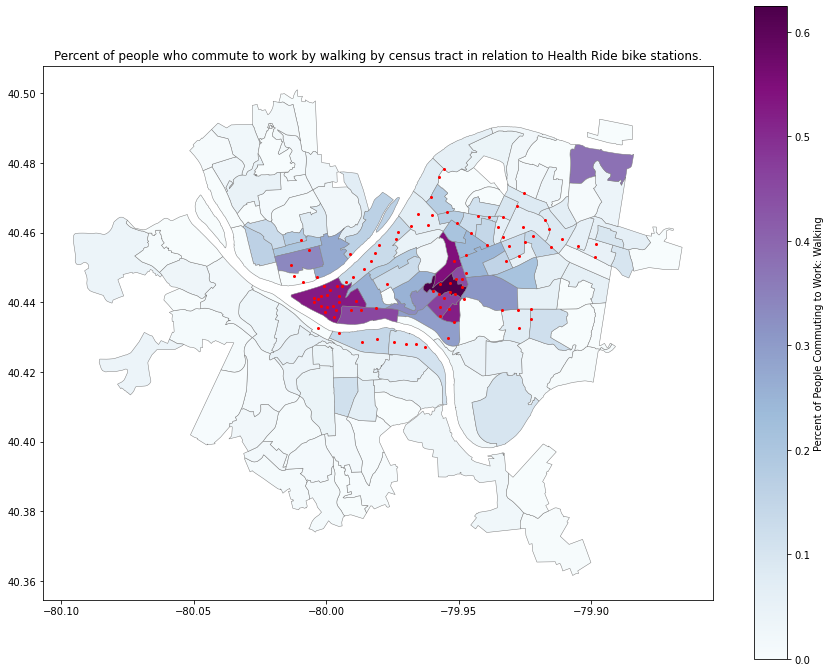

In [54]:
ax_cmw = merged_df.plot(column="perc_walk", cmap='BuPu', figsize = (15, 12), edgecolor = "grey", linewidth = 0.5, 
                        legend=True, legend_kwds={'label': "Percent of People Commuting to Work: Walking",
                                                  'orientation': "vertical"})
#add the bike station locations
hr_gdf.plot(ax=ax_cmw, color="Red", markersize=4)
plt.title("Percent of people who commute to work by walking by census tract in relation to Health Ride bike stations.")

#### Plotting the percentage of people who commute to work by other means

Text(0.5, 1.0, 'Percent of people who commute to work via other means.')

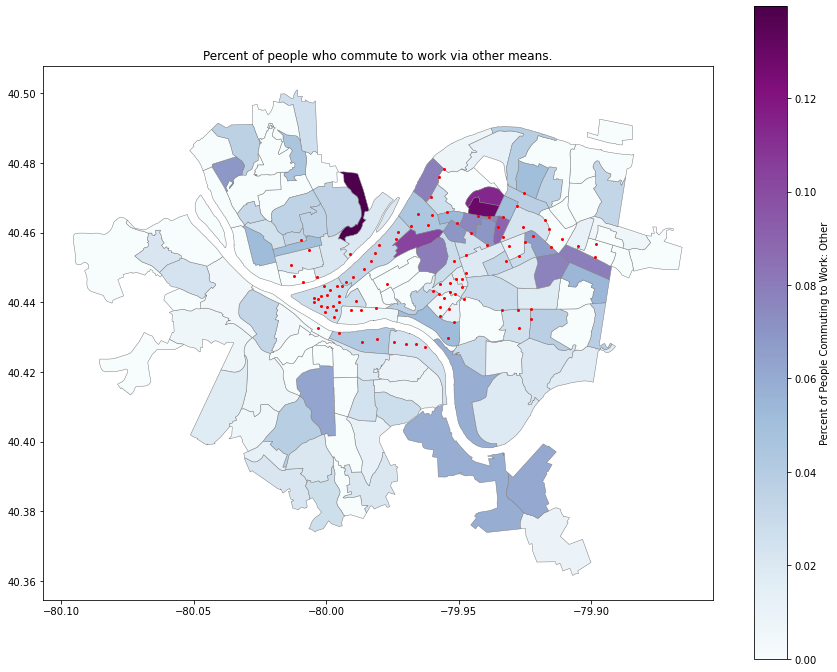

In [58]:
ax_cmo = merged_df.plot(column="perc_other", cmap='BuPu', figsize = (15, 12), edgecolor = "grey", linewidth = 0.5, 
                        legend=True, legend_kwds={'label': "Percent of People Commuting to Work: Other",
                                                  'orientation': "vertical"})
#add the bike station locations
hr_gdf.plot(ax=ax_cmo, color="Red", markersize=4)
plt.title("Percent of people who commute to work via other means.")

#### Plotting the percentage of people who use public transit, walk, and other

Text(0.5, 1.0, 'Percent of people who commute to work via public transit, walking, or other.')

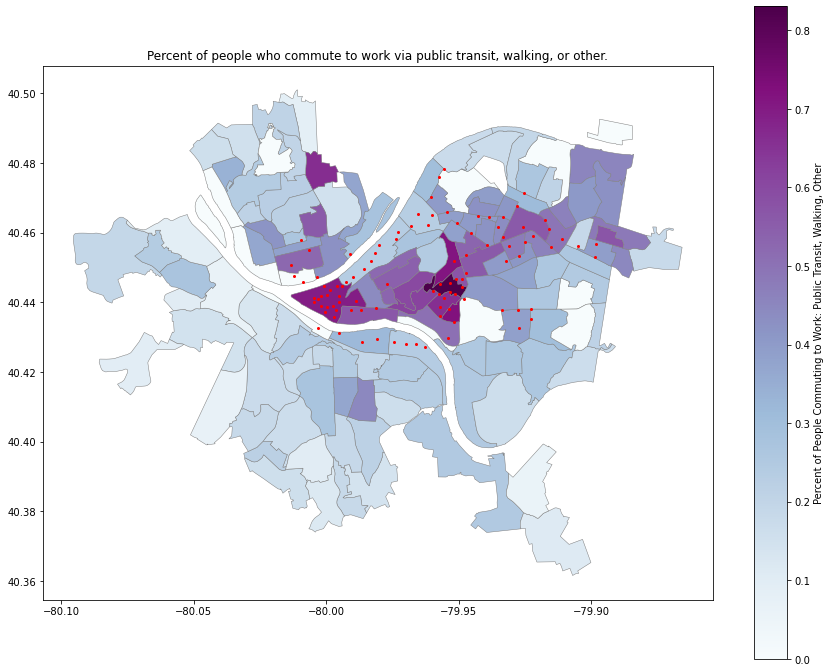

In [55]:
ax_cm3 = merged_df.plot(column="perc_combo", cmap='BuPu', figsize = (15, 12), edgecolor = "grey", linewidth = 0.5, 
                        legend=True, legend_kwds={'label': "Percent of People Commuting to Work: Public Transit, Walking, Other",
                                                  'orientation': "vertical"})
#add the bike station locations
hr_gdf.plot(ax=ax_cm3, color="Red", markersize=4)
plt.title("Percent of people who commute to work via public transit, walking, or other.")

#### Plotting the mean travel time to work and where bikes are located

Text(0.5, 1.0, 'Mean travel time to work by census tract in relation to Healthy Ride Bike Stations')

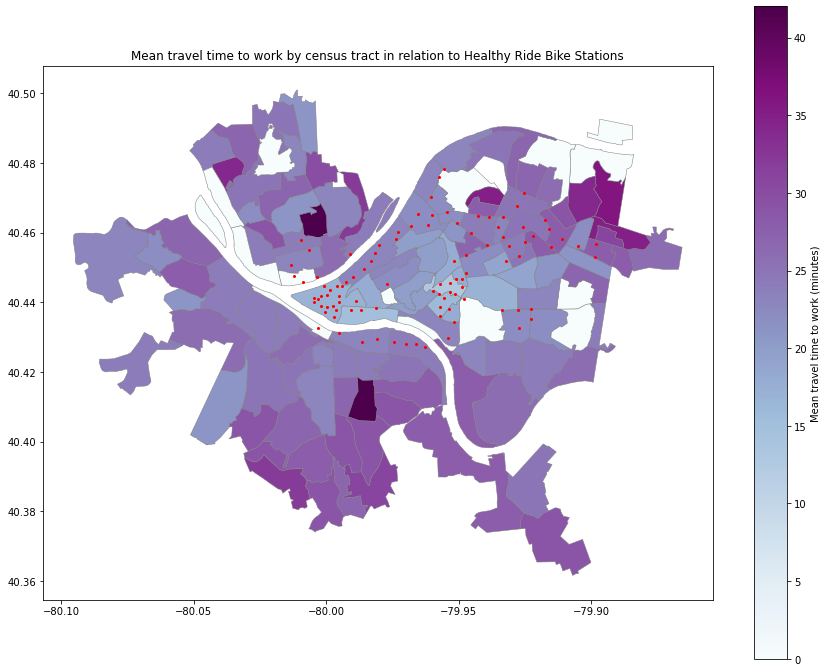

In [59]:
ax_cm4 = merged_df.plot(column="mean_travel_time_to_work", cmap='BuPu', figsize = (15, 12), edgecolor = "grey", 
                        linewidth = 0.5, legend=True, legend_kwds={'label': "Mean travel time to work (minutes)",
                                                                   'orientation': "vertical"})
#add the bike station locations
hr_gdf.plot(ax=ax_cm4, color="Red", markersize=4)
plt.title("Mean travel time to work by census tract in relation to Healthy Ride Bike Stations")

### Income levels by Census Tract
Analyzing the relationship between the location of the bike stations and the income of each census tract

#### Cleaning the dataframe

In [12]:
# in_df = in_df.drop(columns=['Unnamed: 0'])
in_df = in_df.astype({'tractce10': 'str'})

for row, col in in_df.iterrows():
    #fix census tract number
    cen_num = in_df.loc[row]['tractce10']
    if len(cen_num) < 6:
        cen_num = '0' + cen_num
    in_df.at[row, 'tractce10'] = cen_num
        
in_df.head(1)

,Unnamed: 0,tractce10,0,total_households,<$10K,$10K-15K,$15K-25K,$25K-35K,$35K-50K,$50K-75K,...,34,35,36,37,38,39,40,41,med_earnings_male_full-time,med_earnings_female_full-time
0,0,010300,322,39,49,92,20,9,59,10,...,0,"23,272","40,104","8,438",179,"25,865","50,079","4,735",44464,31083


#### Merging the dataframes

In [13]:
cenTract.tractce10.astype(str)
merged_in_df = cenTract.merge(in_df, on="tractce10")
merged_in_df.head(1)

,objectid,statefp10,countyfp10,tractce10,blkgrpce10,geoid10,namelsad10,mtfcc10,funcstat10,aland10,...,34,35,36,37,38,39,40,41,med_earnings_male_full-time,med_earnings_female_full-time
0,1,42,003,040500,1,420030405001,Block Group 1,G5030,S,268195,...,0,"38,352","45,006","8,542","1,005","11,753","19,215","5,300",0,27670


#### Plotting the mean household income

Text(0.5, 1.0, 'Mean Household Income by census tract in relation to Healthy Ride bike stations')

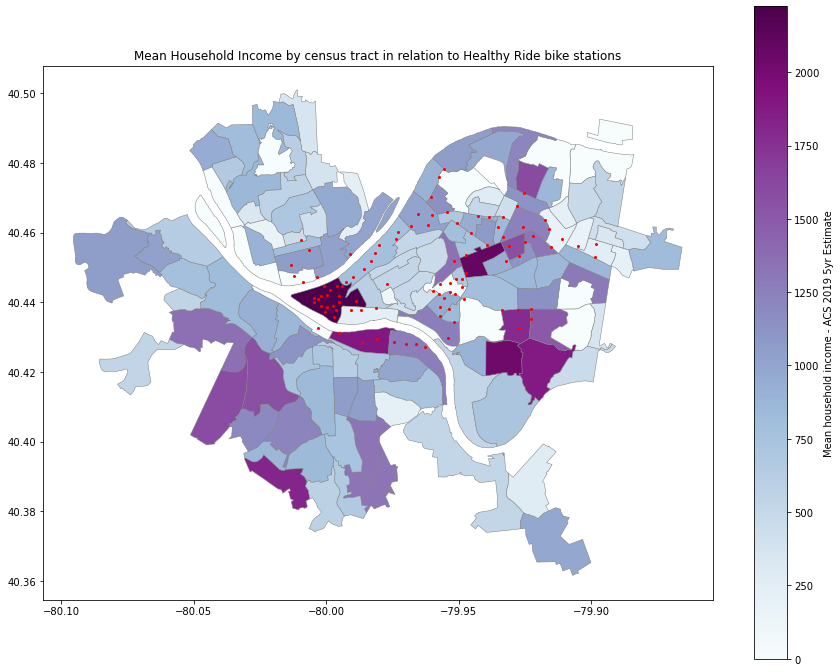

In [60]:
ax_in = merged_in_df.plot(column="mean_hh_income", cmap='BuPu', figsize = (15, 12), edgecolor = "grey", 
                          linewidth = 0.5, legend=True, legend_kwds={'label': "Mean household income - ACS 2019 5yr Estimate",
                                                                     'orientation': "vertical"})
#add the bike station locations
hr_gdf.plot(ax=ax_in, color="Red", markersize=4)
plt.title("Mean Household Income by census tract in relation to Healthy Ride bike stations")

In [15]:
merged_in_df.dtypes

objectid                          int64
statefp10                        object
countyfp10                       object
tractce10                        object
blkgrpce10                       object
                                  ...  
39                               object
40                               object
41                               object
med_earnings_male_full-time       int64
med_earnings_female_full-time     int64
Length: 77, dtype: object

#### Plotting the median earning for Females

Text(0.5, 1.0, 'Median earning for Female.')

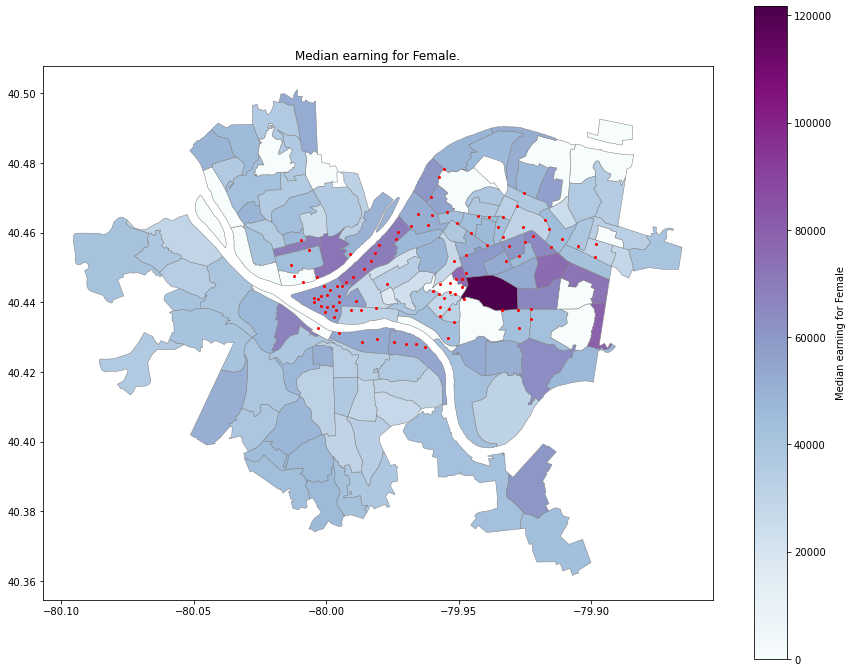

In [17]:
ax_in2 = merged_in_df.plot(column="med_earnings_female_full-time", cmap='BuPu', figsize = (15, 12), edgecolor = "grey", 
                          linewidth = 0.5, legend=True, legend_kwds={'label': "Median earning for Female",
                                                                     'orientation': "vertical"})
#add the bike station locations
hr_gdf.plot(ax=ax_in2, color="Red", markersize=4)
plt.title("Median earning for Female.")

### Employment Status by Census Tract

#### Cleaning the dataframe

In [29]:
pop_df = pop_df.drop(columns=['Unnamed: 0'])
pop_df = pop_df.astype({'tractce10': 'str'})

for row, col in pop_df.iterrows():
    #fix census tract number
    cen_num = pop_df.loc[row]['tractce10']
    if len(cen_num) < 6:
        cen_num = '0' + cen_num
    pop_df.at[row, 'tractce10'] = cen_num
        
pop_df.head(1)

,tractce10,population_16yrs+,in_labor_force,civ_labor_force,employed,unemployed,armed forces,not_in_labor_force,civ_labor_force.1,unemployement_rate,females_16yr+,in_labor_force.1,civ_labor_force.2,employed.1,13,14,15,16
0,010300,6530,1882,1882,1684,198,0,"4,648","1,882",(X),"2,779","1,273","1,273","1,161",94,84,15,0


#### Merging the dataframes

In [30]:
cenTract.tractce10.astype(str)
merged_pop_df = cenTract.merge(pop_df, on="tractce10")
merged_pop_df.head(1)

,objectid,statefp10,countyfp10,tractce10,blkgrpce10,geoid10,namelsad10,mtfcc10,funcstat10,aland10,...,civ_labor_force.1,unemployement_rate,females_16yr+,in_labor_force.1,civ_labor_force.2,employed.1,13,14,15,16
0,1,42,003,040500,1,420030405001,Block Group 1,G5030,S,268195,...,"1,805",(X),"1,760","1,078","1,078","1,018",0,0,0,0


In [31]:
merged_pop_df['perc_unemp'] = merged_pop_df['unemployed'] / merged_pop_df['civ_labor_force']

for row, col in merged_pop_df.iterrows():
    if pd.isna(merged_pop_df.loc[row]['perc_unemp']):
        merged_pop_df.at[row,'perc_unemp'] = 0

Text(0.5, 1.0, 'Percent of Adults 16yrs+ unemployed')

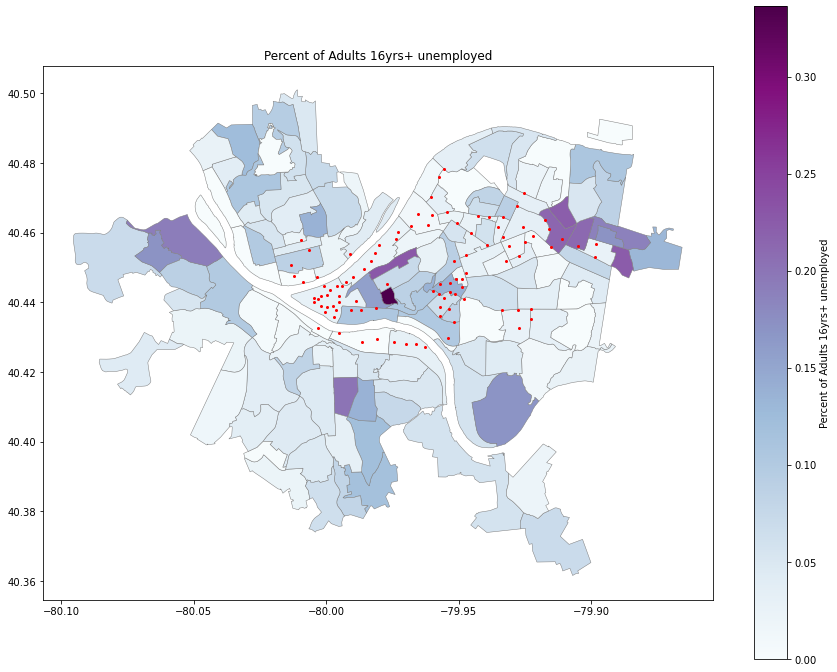

In [33]:
ax_pop = merged_pop_df.plot(column="perc_unemp", cmap='BuPu', figsize = (15, 12), edgecolor = "grey", 
                          linewidth = 0.5, legend=True, legend_kwds={'label': "Percent of Adults 16yrs+ unemployed",
                                                                     'orientation': "vertical"})
#add the bike station locations
hr_gdf.plot(ax=ax_pop, color="Red", markersize=4)
plt.title("Percent of Adults 16yrs+ unemployed")

### Plotting Poor Housing Conditions

In [43]:
poorHouseCon = gpd.read_file('../Data/poorhousingcondition/Poor_Housing_Condition.shp')

#Getting the poor housing conditions values
poorCond_data = pd.DataFrame(poorHouseCon['PPoorCon'])
poorCond_data = poorCond_data.join(poorHouseCon['TRACTCE'])
poorCond_data = poorCond_data.rename(columns={'TRACTCE': 'tractce10'})
poorCond_data = pd.DataFrame(poorHouseCon['PPoorCon'])
poorCond_data = poorCond_data.join(poorHouseCon['TRACTCE'])
poorCond_data = poorCond_data.rename(columns={'TRACTCE': 'tractce10'})

PPHC_cenTract = cenTract.merge(poorCond_data, on="tractce10")
PPHC_cenTract

,objectid,statefp10,countyfp10,tractce10,blkgrpce10,geoid10,namelsad10,mtfcc10,funcstat10,aland10,...,cnt_tractc,sum_lowmod,sum_lowm_1,lowmodperc,lowmodpe_1,cdbg2018,Shape__Are,Shape__Len,geometry,PPoorCon
0,1,42,003,040500,1,420030405001,Block Group 1,G5030,S,268195,...,2,2775,2985,92.964824,92.96,Yes,5.079492e+06,10442.036450,"POLYGON ((-79.95304 40.44203, -79.95302 40.442...",0.000000
1,2,42,003,040400,1,420030404001,Block Group 1,G5030,S,75472,...,2,1365,2020,67.574257,67.57,Yes,2.105489e+06,6609.688123,"POLYGON ((-79.94727 40.44703, -79.94716 40.446...",0.000000
2,3,42,003,040200,2,420030402002,Block Group 2,G5030,S,282679,...,2,1070,1290,82.945736,82.94,Yes,5.998649e+06,18280.484081,"POLYGON ((-79.96230 40.44294, -79.96220 40.442...",0.037139
3,4,42,003,030500,2,420030305002,Block Group 2,G5030,S,284548,...,2,1635,2130,76.760563,76.76,Yes,7.203631e+06,15694.771444,"POLYGON ((-79.98275 40.44641, -79.98273 40.446...",0.000000
4,5,42,003,980000,1,420039800001,Block Group 1,G5030,S,637235,...,1,65,220,29.545455,29.54,No,7.764866e+06,13581.875089,"POLYGON ((-79.88460 40.49066, -79.88451 40.486...",0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,134,42,003,270100,2,420032701002,Block Group 2,G5030,S,604710,...,2,945,2475,38.181818,38.18,No,1.107355e+07,14197.343518,"POLYGON ((-80.03882 40.48725, -80.03805 40.487...",0.000000
134,135,42,003,980900,1,420039809001,Block Group 1,G5030,S,1453388,...,2,0,0,0.000000,0,No,1.564899e+07,29884.799775,"MULTIPOLYGON (((-80.03668 40.47004, -80.03649 ...",0.000000
135,136,42,003,250700,1,420032507001,Block Group 1,G5030,S,560320,...,1,555,765,72.549020,72.54,Yes,6.050817e+06,11709.518764,"POLYGON ((-80.02039 40.46285, -80.02022 40.462...",0.054264
136,137,42,003,270400,1,420032704001,Block Group 1,G5030,S,395541,...,1,675,1035,65.217391,65.21,Yes,4.256393e+06,9062.212499,"POLYGON ((-80.02675 40.46778, -80.02665 40.467...",0.028037


Text(0.5, 1.0, 'Percent of Poor Housing Condition by census tract in relation to Healthy Ride bike stations')

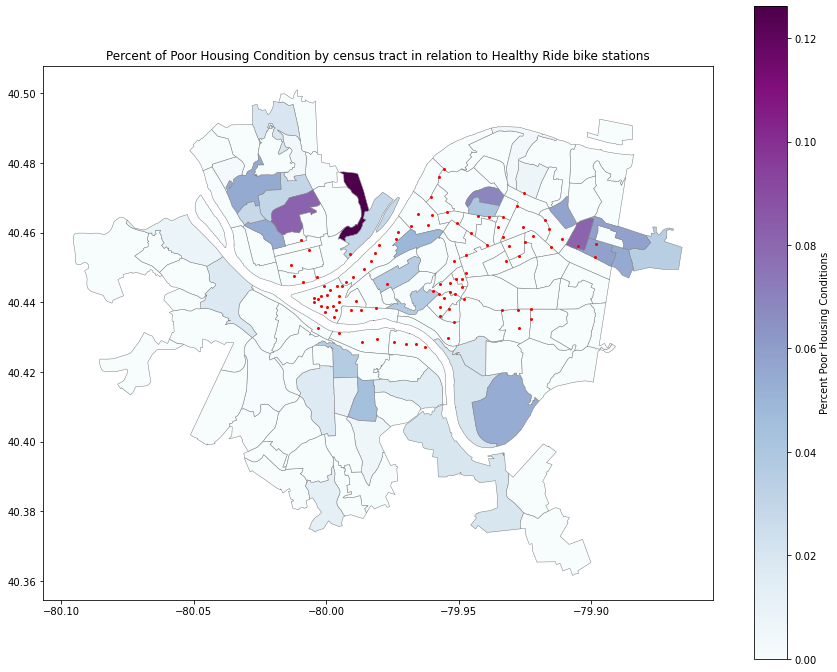

In [61]:

#plotting the poor housing condition data on the pittsburgh neighborhood map (data from 2016)
ax_pphc = PPHC_cenTract.plot(column="PPoorCon", cmap='BuPu', figsize = (15, 12), edgecolor = "grey", linewidth = 0.5, legend=True, legend_kwds={'label': "Percent Poor Housing Conditions",'orientation': "vertical"})

#now adding the bike station location data on top of this map as an overlay
hr_gdf.plot(ax=ax_pphc, color="Red", markersize=4)
plt.title("Percent of Poor Housing Condition by census tract in relation to Healthy Ride bike stations")

## New York City, NY